In [2]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install yahooquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [5]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Close"]

In [6]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [7]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib
    from pretty_html_table import build_table

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    
    
    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [8]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=25)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [9]:
# moving average
def get_ma(prices, rate):
    return prices.rolling(rate).mean()



def get_bollinger_bands(prices, rate=7):
    sma = get_ma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    
    macd = pd.DataFrame(exp1 - exp2)
    macd.columns=["macd"]
    
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())
    signal.columns=["signal"]
    
    hist = pd.DataFrame(macd['macd'] - signal['signal'])
    hist.columns=["hist"]
    
    
    
    frames =  [macd, signal, hist]
    
    
    
    df = pd.concat(frames, join = 'inner', axis = 1)
    df["result"]= np.select([df.macd > df.signal , df.macd < df.signal], ["Buy", "Sell"])
    return df




#HISTOGRAM = MACD LINE - SIGNAL LINE

#IF MACD LINE > SIGNAL LINE => BUY THE STOCK
#IF SIGNAL LINE > MACD LINE => SELL THE STOCK

#---------------------------------------------------------------


df_tmp_f = pd.DataFrame()
df_buy_signal=pd.DataFrame()
final_text=""
#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cpx in getCryptoPairs():
    Crypto_Pairs.append(cpx)


for cp in Crypto_Pairs:

    df_tmp_0 = pd.DataFrame(getRates(cp,  '1y',  '1d'))

    bollinger_up, bollinger_down = get_bollinger_bands(df_tmp_0)

    cp_macd=get_macd(getRates(cp,  '1y',  '1d'), 26, 12, 9)
    
    #display(cp_macd.iloc[-7:])

    df_tmp = pd.DataFrame(data=np.column_stack((df_tmp_0.values,bollinger_up,bollinger_down,cp_macd.macd,
                                                cp_macd.signal,cp_macd.result )),
                          columns=['Price','Bol_Up','Bol_Down',"macd","signal","result"])
    df_tmp.insert(0,'Crypto_Pair',cp)
    df_tmp.index=df_tmp_0.index


    #display( df_tmp.iloc[-7:] )
    
    x=round( df_tmp["Bol_Up"].iloc[-90:].mean() ,6 )
    #print("Bol_Up__Mean_for_last_7days   : " + str( x ) )
    
    
    y=round( df_tmp["Bol_Down"].iloc[-90:].mean() ,6 )
    #print("Bol_Down__Mean_for_last_7days : " + str( y ) )
    
    
    df_tmp_2 = pd.DataFrame(data=np.column_stack((cp,df_tmp.iloc[-1].Price,x,y )),
                          columns=["Crypto_Pair",'Price','Bol_Up_30','Bol_Down_30'])
    
    
    #display( df_tmp_2["Bol_Up_30"].values )
    
    x1="Bol_Up__Mean_for_last_7days   : " + str( x )
    y1="Bol_Down__Mean_for_last_7days : " + str( y )
    
    df_tmp_f = df_tmp_f.append(df_tmp.iloc[-7:])
    final_text=final_text+"\n"+cp+"\n"+str(x1)+"\n"+str(y1)
    r0=df_tmp.iloc[-1].Price
    r1= ( df_tmp.iloc[-1].Price+(df_tmp.iloc[-1].Price*0.05) ) 
    r2=float(df_tmp_2["Bol_Up_30"].values) 
    df_tmp_2["%change"]=((r2-r0)/ abs(r0) ) *100
    #print(r1)
    #print(r2)
    if r1<=r2:
        print("BUY_signal")
        df_buy_signal=df_buy_signal.append(df_tmp_2)
        #display(df_buy_signal)
        
#---------------------------------------------------------------------------
#display(df_buy_signal)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands",final_text)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands","")

BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
HEX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
HEX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
DOGE

In [10]:
display(df_buy_signal) 

,Crypto_Pair,Price,Bol_Up_30,Bol_Down_30,%change
0,MATIC-USD,1.1044336557388306,1.209506,1.014172,9.513685
0,SOL-USD,20.94694709777832,23.232573,18.325419,10.911499
0,SHIB-USD,1.1372454537195154e-05,1.2e-05,1e-05,5.518118
0,AVAX-USD,17.645652770996094,18.639614,15.297444,5.632896
0,UNI7083-USD,6.091121196746826,6.782835,5.83448,11.356100
0,ATOM-USD,11.356703758239746,13.445844,11.492915,18.395657


In [11]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=10)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [12]:
def getRatesTable(*args):
    df_table = pd.DataFrame()
    for cp in args:
        df10yr=getRates(cp, '10y',  '1d')
        df5yr=getRates(cp,  '5y',  '1d')
        df3yr=getRates(cp,  '3y',  '1d')
        df1yr=getRates(cp,  '1y',  '1d')
        df3mo=getRates(cp,  '3mo',  '1h')
        df1mo=getRates(cp,  '1mo',  '1h')
        df1wk=getRates(cp,  '1wk',  '1h')
        df1dy=getRates(cp,  '1dy',  '1h')
        new_row = pd.Series(data={
                                   'Crypto_Pair':cp,
                                   '10yr_d_CHG%':getPercChange(df10yr)[0],
                                   '5yr_d_CHG%':getPercChange(df5yr)[0],
                                   '3yr_d_CHG%':getPercChange(df3yr)[0],
                                   '1yr_d_CHG%':getPercChange(df1yr)[0], 
                                   '3mo_h_CHG%':getPercChange(df3mo)[0], 
                                   '1mo_h_CHG%':getPercChange(df1mo)[0] ,
                                   '1wk_h_CHG%':getPercChange(df1wk)[0],
                                   '1dy_h_CHG%':getPercChange(df1dy)[0], 
                                 } 
                           )
        
        df_table = df_table.append(new_row, ignore_index=True)
    return df_table

#--------------------------------------------------------------------


#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cp in getCryptoPairs():
    Crypto_Pairs.append(cp)

dfx=getRatesTable(*Crypto_Pairs)

#dfx

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

In [13]:
display(df_buy_signal)

,Crypto_Pair,Price,Bol_Up_30,Bol_Down_30,%change
0,MATIC-USD,1.1044336557388306,1.209506,1.014172,9.513685
0,SOL-USD,20.94694709777832,23.232573,18.325419,10.911499
0,SHIB-USD,1.1372454537195154e-05,1.2e-05,1e-05,5.518118
0,AVAX-USD,17.645652770996094,18.639614,15.297444,5.632896
0,UNI7083-USD,6.091121196746826,6.782835,5.83448,11.356100
0,ATOM-USD,11.356703758239746,13.445844,11.492915,18.395657


In [14]:
def mail2me_v2(df,mail_subject,message_text):
    
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from smtplib import SMTP
    import smtplib
    import sys


    recipients = ['ozukun83@gmail.com'] 
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = mail_subject
    msg['From'] = 'ozukun83@gmail.com'

    password = input("Type your password and press enter: ")
    

    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    body = message_text
    body = MIMEText(body) # convert the body to a MIME compatible string
    msg.attach(body)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login("ozukun83@gmail.com",password)
    server.sendmail(msg['From'], emaillist , msg.as_string())
    print("Mail succeed !!")
    
#---------------------------------------------------------------------------
#mail2me_v2(dfx,"Crypto Rate changes","")

ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed


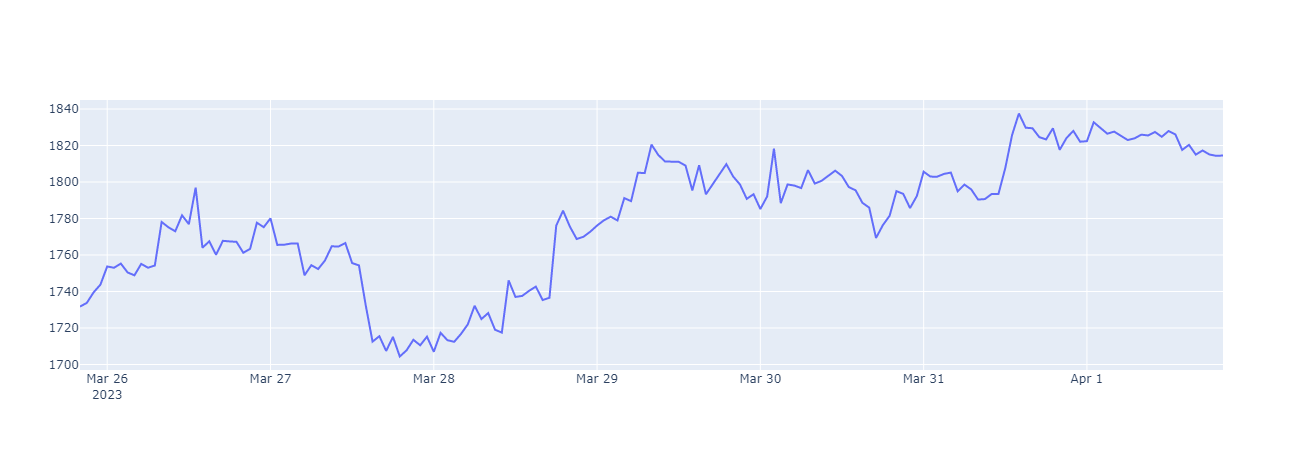

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


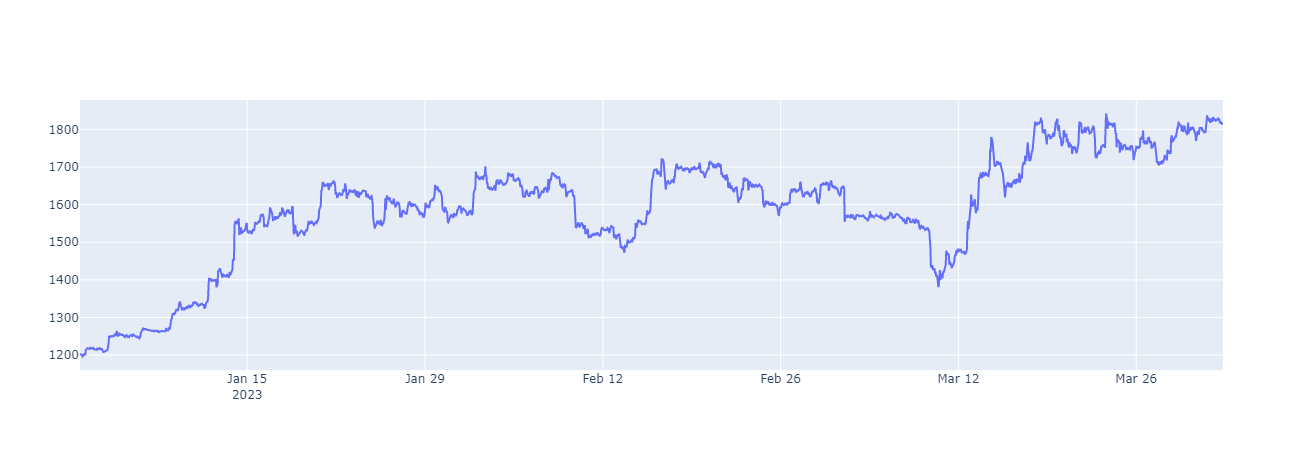

In [15]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()
    
#------------------------------------------------

#( getLine(getRates('ETH-USD',  '1d',  '1h')) )
( getLine(getRates('ETH-USD',  '1wk',  '1h')) )
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
#( getLine(getRates('ETH-USD',  '3y',  '1d')) )

In [16]:

html = dfx.to_html()
# Write the HTML to a file
with open('crypto_change.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,6105.9636,314.6848,329.5890,-38.6755,70.8322,21.0728,3.6701,-0.1841
1,ETH-USD,465.4724,377.9972,1237.7938,-47.3987,50.9580,10.5195,4.7806,-0.4321
2,BNB-USD,15701.1925,2742.5783,2368.8055,-29.5651,28.1529,4.2659,-2.3862,-0.7773
3,XRP-USD,133.7343,4.7957,189.9471,-38.5865,49.9783,32.6853,12.3221,-4.7415
4,HEX-USD,46188.3041,46188.3041,18180.1386,-48.3952,312.9650,5.3113,-7.6825,-9.8393
5,ADA-USD,1131.1016,161.7299,1178.9013,-66.1407,58.5969,10.0260,12.0003,-0.2313
6,DOGE-USD,5701.7668,2919.3086,4297.1612,-41.9064,16.3264,0.8080,11.6893,6.3503
7,STETH-USD,205.5563,205.5563,205.5563,-47.6573,52.2829,10.2130,3.9349,-0.4928


In [17]:
html = df_tmp_f.to_html()
# Write the HTML to a file
with open('crypto_bol.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-03-26,BTC-USD,27994.330078,28567.671322,27022.838722,1375.411028,1149.631528,Buy
2023-03-27,BTC-USD,27139.888672,28624.849839,26786.418018,1293.317214,1178.368665,Buy
2023-03-28,BTC-USD,27268.130859,28440.092333,26711.836796,1224.490188,1187.59297,Buy
2023-03-29,BTC-USD,28348.441406,28721.299079,26728.059738,1242.790194,1198.632415,Buy
2023-03-30,BTC-USD,28033.5625,28576.620954,26786.90639,1217.846409,1202.475214,Buy
2023-03-31,BTC-USD,28478.484375,28875.038101,26769.974734,1219.91731,1205.963633,Buy
2023-04-01,BTC-USD,28381.982422,29030.873039,26867.64705,1199.939457,1204.758798,Sell
2023-03-26,ETH-USD,1775.676758,1833.752675,1699.873196,48.144327,41.324738,Buy
2023-03-27,ETH-USD,1715.460815,1838.408519,1689.542932,42.734196,41.606629,Buy


In [18]:
from datetime import timedelta
df_ALGO = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))
date=df_ALGO.index[-1]+ timedelta(days=1)

print(df_ALGO)

df_ALGO.loc[date, :] = [0]


print(df_ALGO.size)

df_ALGO['S1'] = df_ALGO['Close'].shift(1)
df_ALGO['SMA3'] = df_ALGO['Close'].rolling(3).mean().shift(1)
df_ALGO['SMA5'] = df_ALGO['Close'].rolling(5).mean().shift(1)
df_ALGO['SMA15'] = df_ALGO['Close'].rolling(15).mean().shift(1)
df_ALGO['SMA30'] = df_ALGO['Close'].rolling(30).mean().shift(1)

df_ALGO['S1'] = df_ALGO['S1'].fillna(0)
df_ALGO['SMA3'] = df_ALGO['SMA3'].fillna(0)
df_ALGO['SMA5'] = df_ALGO['SMA5'].fillna(0)
df_ALGO['SMA15'] = df_ALGO['SMA15'].fillna(0)
df_ALGO['SMA30'] = df_ALGO['SMA30'].fillna(0)



X = df_ALGO.iloc[:, 1:-1].values
y = df_ALGO.iloc[:, 0].values



df_ALGO

ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
               Close
Date                
2019-06-21  3.201412
2019-06-22  2.158967
2019-06-23  1.890702
2019-06-24  1.383728
2019-06-25  1.537290
...              ...
2023-03-27  0.200274
2023-03-28  0.202006
2023-03-29  0.234327
2023-03-30  0.224584
2023-04-01  0.221622

[1380 rows x 1 columns]
1381


,Close,S1,SMA3,SMA5,SMA15,SMA30
Date,,,,,,
2019-06-21,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-22,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000
2019-06-23,1.890702,2.158967,0.000000,0.000000,0.000000,0.000000
2019-06-24,1.383728,1.890702,2.417027,0.000000,0.000000,0.000000
2019-06-25,1.537290,1.383728,1.811132,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2023-03-28,0.202006,0.200274,0.205881,0.209311,0.213933,0.218843
2023-03-29,0.234327,0.202006,0.204370,0.205774,0.213204,0.217053
2023-03-30,0.224584,0.234327,0.212202,0.210795,0.213977,0.216356


In [ ]:
# RNN Implementation FOR ALGO-USD pair

df_RNN = pd.DataFrame(columns=['Pair','p_units' ,'p_epoch' ,'p_batch_size' ,'prediction'])


df_alg = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))
date=df_alg.index[-1]+ timedelta(days=1)
df_alg.loc[date, :] = [0]


for i in range (1,181):
    a="Close_"+str(i)
    #print(a)
    df_alg[a]=df_alg['Close'].shift(i)

df_alg=df_alg.fillna(0)
display(df_alg)


X = df_alg.iloc[:, 1:].values
y = df_alg.iloc[:, 0].values

print(y.shape)
print(y)
y=y.reshape(-1,1)
print(y)

def calc_LTSM( p_units ,p_epoch ,p_batch_size ):
    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    X_scaled = sc.fit_transform(X)
    y_scaled = sc.fit_transform(y)
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.1, shuffle=False)
    # Reshaping
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # Importing the Keras libraries and packages
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers import Dropout
    regressor = Sequential()
    
    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = p_units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = p_units, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = p_units))
    regressor.add(Dropout(0.2))

    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, epochs = p_epoch, batch_size = p_batch_size)
    
    lastElementIndex = len(X_test)-1
    # Removing the last element using slicing 
    X_pre = X_test[:lastElementIndex]
    y_pre = y_test[:lastElementIndex]
    X_pre = np.array(X_pre)
    X_pre = np.reshape(X_pre, (X_pre.shape[0], X_pre.shape[1], 1)) #   lenght of dataset,lenght of time_series , nof_input
    predicted_stock_price = regressor.predict(X_pre)
    #print("*****")
    #print(predicted_stock_price)
    
    index1 = len(X_test)-1
    index2 = len(X_test)
    X_final = X_test[index1:index2]
    y_final = y_test[index1:index2]
    X_final = np.array(X_final)
    X_final = np.reshape(X_final, (X_final.shape[0], X_final.shape[1], 1))
    
    print(y_final)
    print("Params: "+str(p_units)+" "+str(p_epoch)+" "+str(p_batch_size) )
    predicted_stock_price = regressor.predict(X_final)
    predicted_stock_price_f = sc.inverse_transform(predicted_stock_price)
    
    row1 = pd.Series(["ALGO-USD",p_units ,p_epoch ,p_batch_size,predicted_stock_price_f] ,index=df_RNN.columns )
    print(row1)
    df_RNN.loc[len(df_RNN.index)] = row1
    display(df_RNN)
    return predicted_stock_price_f



x1=calc_LTSM(160,10,300)
print(x1)
x2=calc_LTSM(160,50,300)
print(x2)
x3=calc_LTSM(160,100,300)
print(x3)



display(df_RNN)
print(df_RNN.prediction.mean)

ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,Close,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Close_8,Close_9,...,Close_171,Close_172,Close_173,Close_174,Close_175,Close_176,Close_177,Close_178,Close_179,Close_180
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-21,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-22,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-23,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-24,1.383728,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-25,1.537290,1.383728,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-28,0.202006,0.200274,0.210829,0.206541,0.209219,0.219691,0.214062,0.224551,0.210182,0.221018,...,0.334289,0.341346,0.348689,0.353801,0.357408,0.354747,0.354266,0.355096,0.352421,0.354938
2023-03-29,0.234327,0.202006,0.200274,0.210829,0.206541,0.209219,0.219691,0.214062,0.224551,0.210182,...,0.338705,0.334289,0.341346,0.348689,0.353801,0.357408,0.354747,0.354266,0.355096,0.352421
2023-03-30,0.224584,0.234327,0.202006,0.200274,0.210829,0.206541,0.209219,0.219691,0.214062,0.224551,...,0.320155,0.338705,0.334289,0.341346,0.348689,0.353801,0.357408,0.354747,0.354266,0.355096


(1381,)
[3.20141196 2.15896702 1.89070201 ... 0.224584   0.22162159 0.        ]
[[3.20141196]
 [2.15896702]
 [1.89070201]
 ...
 [0.224584  ]
 [0.22162159]
 [0.        ]]
Epoch 1/10
5/5 [==============================] - 20s 2s/step - loss: 0.0422
Epoch 2/10
5/5 [==============================] - 13s 3s/step - loss: 0.0252
Epoch 3/10
5/5 [==============================] - 12s 2s/step - loss: 0.0243
Epoch 4/10
5/5 [==============================] - 13s 2s/step - loss: 0.0238
Epoch 5/10
5/5 [==============================] - 13s 2s/step - loss: 0.0240
Epoch 6/10
5/5 [==============================] - 12s 2s/step - loss: 0.0235
Epoch 7/10
5/5 [==============================] - 13s 3s/step - loss: 0.0243
Epoch 8/10
5/5 [==============================] - 12s 2s/step - loss: 0.0241
Epoch 9/10
5/5 [==============================] - 13s 3s/step - loss: 0.0235
Epoch 10/10
5/5 [==============================] - 13s 2s/step - loss: 0.0238
[[0.]]
Params: 160 10 300
Pair                  ALGO-USD
p_

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,160,10,300,[[0.62600124]]


[[0.62600124]]
Epoch 1/50
5/5 [==============================] - 20s 3s/step - loss: 0.0429
Epoch 2/50
5/5 [==============================] - 13s 2s/step - loss: 0.0258
Epoch 3/50
5/5 [==============================] - 13s 2s/step - loss: 0.0250
Epoch 4/50
5/5 [==============================] - 13s 2s/step - loss: 0.0239
Epoch 5/50
5/5 [==============================] - 12s 2s/step - loss: 0.0240
Epoch 6/50
5/5 [==============================] - 13s 3s/step - loss: 0.0237
Epoch 7/50
5/5 [==============================] - 13s 2s/step - loss: 0.0237
Epoch 8/50
5/5 [==============================] - 13s 3s/step - loss: 0.0239
Epoch 9/50
5/5 [==============================] - 13s 2s/step - loss: 0.0234
Epoch 10/50
5/5 [==============================] - 12s 2s/step - loss: 0.0236
Epoch 11/50
5/5 [==============================] - 13s 3s/step - loss: 0.0235
Epoch 12/50
5/5 [==============================] - 12s 2s/step - loss: 0.0237
Epoch 13/50
5/5 [==============================] - 13s 3s/

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,160,10,300,[[0.62600124]]
1,ALGO-USD,160,50,300,[[0.60252833]]


[[0.60252833]]
Epoch 1/100
5/5 [==============================] - 20s 3s/step - loss: 0.0421
Epoch 2/100
5/5 [==============================] - 13s 2s/step - loss: 0.0248
Epoch 3/100
5/5 [==============================] - 13s 2s/step - loss: 0.0237
Epoch 4/100
5/5 [==============================] - 14s 3s/step - loss: 0.0241
Epoch 5/100
5/5 [==============================] - 14s 3s/step - loss: 0.0242
Epoch 6/100
5/5 [==============================] - 14s 3s/step - loss: 0.0238
Epoch 7/100
5/5 [==============================] - 13s 2s/step - loss: 0.0236
Epoch 8/100
5/5 [==============================] - 13s 3s/step - loss: 0.0239
Epoch 9/100
5/5 [==============================] - 13s 2s/step - loss: 0.0242
Epoch 10/100
5/5 [==============================] - 13s 2s/step - loss: 0.0241
Epoch 11/100
5/5 [==============================] - 13s 3s/step - loss: 0.0234
Epoch 12/100
5/5 [==============================] - 13s 2s/step - loss: 0.0234
Epoch 13/100
5/5 [============================

In [ ]:
#****---------------------------------------------------------------------------------------------------------------------------



In [ ]:
for x in df_RNN.prediction:
    print(float(x))
    


In [ ]:
df_ada = pd.DataFrame(getRates('ADA-USD',  '10y',  '1d'))

display((df_ada))


df_ada["s1"]=df_ada["Close"].shift(1)

z=df_ada.iloc[2]

print(z)

In [ ]:
Crypto_Pairs=["BTC-USD","ETH-USD","ADA-USD","ALG-USD","XRP-USD"]



dfx=getRatesTable(*Crypto_Pairs)

display(dfx)

display( dfx.iloc[2:,0:4].values )

z=dfx.iloc[2:,0:4].values

display(z.shape)
display(type(z))

In [ ]:
from datetime import timedelta


dfe0=getRates('ETH-USD',  '10y',  '1d')


display(type(dfe0))


display(dfe0)

date=dfe0.index[0]+ timedelta(days=-1)
s1 = pd.Series([0],index=[date])

dfe1=s1.append(dfe0)

display(dfe1)


In [ ]:
#ANN SAMPLE

'''
import tensorflow as tf
from tensorflow.keras.layers import Dense



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)


ann=tf.keras.Sequential()
ann.add(tf.keras.layers.Dense(units=12,
                              activation="relu"))

ann.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
#ann.compile(loss='mean_squared_error', optimizer='adam' ,metrics=['mse'])

 Fitting the ANN to the Training set
ann.fit(X_train, y_train ,batch_size = 50, epochs = 100)
'''
